## System

The variables are $s$, $w$ and $r$ with the constants: $S$, $W$, $R$, $D$ and $R^{'}$

$
\begin{align}
\min f(s, w, r) \\
s.t. \nonumber \\ 
& \frac{S}{s} + \frac{W}{w} + \frac{R}{r} \leq D \\
& s + r \leq R^{'} \\
\end{align}
$

### KKT

Using the example $f(s, w, r) = s^2 + w^2 + r^2$, then this resulting set of equations are
$
\begin{equation}
L(s, w, r, \lambda_1, \lambda_2) = f(s, w, r) + \lambda_1(\frac{S}{s} + \frac{W}{w} + \frac{R}{r} - D) + \lambda_2(s + r - R^{'}) \\
\end{equation}
$

$
\Delta L(s, w, r) = \begin{bmatrix}
\frac{\partial L}{\partial s} = 2s - \frac{\lambda_1 S}{s^2} + \lambda_2 = 0 \\
\frac{\partial L}{\partial w} = 2w - \frac{\lambda_1 W}{w^2} = 0 \\
\frac{\partial L}{\partial r} = 2r - \frac{\lambda_1 R}{r^2} + \lambda_2 = 0 \\
\frac{\partial L}{\partial \lambda_1} = \frac{S}{s} + \frac{W}{w} + \frac{R}{r} - D = 0 \\
\frac{\partial L}{\partial \lambda_2} = s + r - R^{'} = 0
\end{bmatrix}
$

$
\begin{equation}
0 \leq \lambda_1 \\
0 \leq \lambda_2 \\
\lambda_1 (\frac{S}{s} + \frac{W}{w} + \frac{R}{r} - D) = 0 \\
\lambda_2 (s + r - R^{'}) = 0 \\
\end{equation}
$

### Solving KKT

$
\begin{equation}
2s^3 - \lambda_1 S + \lambda_2 s^2 = 0 \\
2w^3 - \lambda_1 W = 0 \\
2r^3 - \lambda_1 R + \lambda_2 r^2 = 0 \\
\frac{S}{s} + \frac{W}{w} + \frac{R}{r} = D \\
s + r = R^{'}
\end{equation}
$

$
\begin{bmatrix}
? 
\end{bmatrix} \cdot
\begin{bmatrix}
s \\ w \\ r \\ \lambda_1 \\ \lambda_2
\end{bmatrix} = 
\begin{bmatrix}
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 
\end{bmatrix}
$

* Example $f(s,w,r) = s^2 + w^2 + r^2$, I believe this is convex but not strictly convex

$
\begin{equation}
g(s, w, r) = \frac{S}{s} + \frac{W}{w} + \frac{R}{r} \leq D \\
g_s(s, w, r) = -\frac{S}{s^2} \\
g_w(s, w, r) = -\frac{W}{w^2} \\
g_r(s, w, r) = -\frac{R}{r^2} \\
\end{equation}
$

$
\begin{bmatrix}
\frac{2S}{s^3} & 0 & 0 \\
0 & \frac{2W}{w^3} & 0 \\
0 & 0 & \frac{2R}{r^3} \\
\end{bmatrix}
$

This is semi-defined positive because we know that all variables and constants here are positive

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from docplex.cp.model import CpoModel
from docplex.cp.solution import SOLVE_STATUS_FEASIBLE, SOLVE_STATUS_OPTIMAL
from math import inf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from tqdm import tqdm

from model.model_distribution import load_model_distribution, ModelDistribution

%matplotlib notebook

In [3]:
distribution_name, task_distributions, server_distributions = load_model_distribution('../models/basic_v3.mdl')
model = ModelDistribution(distribution_name, task_distributions, 100, server_distributions, 1)

tasks, servers = model.create()
server = servers[0]

In [4]:
def resource_evaluator(task, server, loading_speed, compute_speed, sending_speed):
    return compute_speed / server.available_computation + \
            (loading_speed + sending_speed) / server.available_bandwidth

### Plot

Task normal 0 - Required storage: 106, computation: 85, results data: 41, deadline: 37, value: 257


<IPython.core.display.Javascript object>


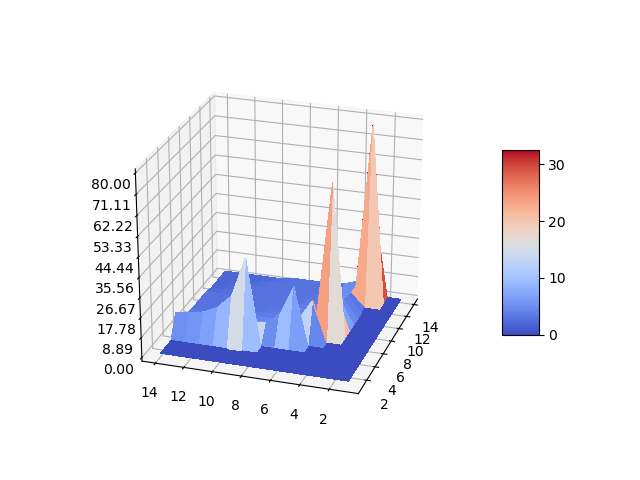

In [7]:
loading_speeds = np.arange(1, 15, 1)
compute_speeds = np.arange(1, 15, 1)
loading_speeds, compute_speeds = np.meshgrid(loading_speeds, compute_speeds)

task = tasks[0]
print(str(task))

sending_speeds = np.zeros(loading_speeds.shape)
evaluation = np.zeros(loading_speeds.shape)
rows, cols = loading_speeds.shape
for col in range(cols):
    for row in range(rows):
        for sending in range(1, server.available_bandwidth):
            if task.required_storage / loading_speeds[row][col] + task.required_computation / compute_speeds[row][col] + task.required_results_data / sending <= task.deadline:
                sending_speeds[row][col] = sending
                evaluation[row][col] = resource_evaluator(task, server, loading_speeds[row][col], 
                                                              compute_speeds[row][col], sending)
                break


# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(loading_speeds, compute_speeds, sending_speeds, 
                       cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.xaxis.set_label('loading speeds')
ax.yaxis.set_label('compute speeds')
ax.zaxis.set_label('sending speeds')

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Iteration

In [7]:
%%time

# Code copied from greedy.resource_allocation_policy
for task in tqdm(tasks):
    solution = min(((s, w, r)
                    for s in range(1, server.available_bandwidth + 1)
                    for w in range(1, server.available_computation + 1)
                    for r in range(1, server.available_bandwidth - s + 1)
                    if task.required_storage * w * r + s * task.required_computation * r +
                    s * w * task.required_results_data <= task.deadline * s * w * r),
                   key=lambda bid: resource_evaluator(task, server, bid[0], bid[1], bid[2]))

 26%|█████████████████████                                                            | 26/100 [04:13<12:02,  9.76s/it]


KeyboardInterrupt: 

### Optimised iteration

In [9]:
%%time

for task in tqdm(tasks):
    min_value, min_solution = inf, None
    break_s, break_w, break_r = True, True, True
    s, w, r = 1, 1, 1
    while s < server.available_bandwidth and break_s:
        while w < server.available_computation and break_w:
            while r < server.available_bandwidth - s and break_r:
                

SyntaxError: unexpected EOF while parsing (<unknown>, line 8)

### Cplex

In [10]:
%%time

for task in tqdm(tasks):
    model = CpoModel('resource allocation')
    
    loading = model.integer_var(min=1, max=server.available_bandwidth)
    compute = model.integer_var(min=1, max=server.available_computation)
    sending = model.integer_var(min=1, max=server.available_bandwidth)
    
    model.add(task.required_storage * compute * sending + 
              loading * task.required_computation * sending +
              sending * compute * task.required_results_data <= 
              task.deadline * loading * compute * sending)
    
    model.minimize(resource_evaluator(task, server, loading, compute, sending))
    model_solution = model.solve(log_output=None)
    
    if model_solution.get_solve_status() != SOLVE_STATUS_FEASIBLE and model_solution.get_solve_status() != SOLVE_STATUS_OPTIMAL:
        print(f'Optimal algorithm failed - status: {model_solution.get_solve_status()}')
    s, w, r = model_solution.get_value(loading), model_solution.get_value(compute), model_solution.get_value(sending)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.46it/s]

Wall time: 3.64 s


### KKT